# Product Classification using TF-IDF, Graph Features, Ensemble Models, and Specialist Models

This notebook extends the implementation from `final_notebook.ipynb` by adding specialist models for classes 1, 10, and 12.

Key additions:
1. Training specialist models using linear SVC for classes 1, 10, and 12
2. Modifying the prediction logic to use these specialist models when:
   - The ensemble model predicts class 1, 10, or 12
   - The prediction probability is less than 0.9
3. If the specialist confirms the class, bump probability to 0.9
4. If the specialist disagrees, swap the two highest probability scores


## 1. Imports and Setup


In [1]:
# General imports
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
import re
import string
import csv
import spacy
from collections import Counter
import joblib

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler, label_binarize

# Models
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_selection import SelectKBest, chi2

# Graph embeddings
import node2vec
from node2vec import Node2Vec
from gensim.models import Word2Vec

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import StratifiedKFold


2025-05-30 17:21:30.474556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748614890.536017   85957 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748614890.553331   85957 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748614890.687418   85957 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748614890.687441   85957 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748614890.687444   85957 computation_placer.cc:177] computation placer alr

## 2. Helper Functions


In [2]:
# Function to create price features (from tfidf_node2vec_classification.ipynb)
def create_price_features(product_ids, price_df):
    """
    Create price-based features for a list of product IDs

    Args:
        product_ids: List of product IDs
        price_df: DataFrame with product_id and price columns

    Returns:
        DataFrame with price features
    """
    # Create a DataFrame with product IDs as index
    price_features = pd.DataFrame(index=product_ids)

    # Map prices to products
    price_dict = dict(zip(price_df['product_id'], price_df['price']))
    price_features['price'] = price_features.index.map(lambda x: price_dict.get(x, np.nan))

    # Fill missing prices with median
    median_price = price_df['price'].median()
    price_features['price'].fillna(median_price, inplace=True)

    # Create price buckets (as binary features)
    price_features['price_0_10'] = (price_features['price'] <= 10).astype(int)
    price_features['price_10_100'] = ((price_features['price'] > 10) & (price_features['price'] <= 100)).astype(int)
    price_features['price_100_plus'] = (price_features['price'] > 100).astype(int)

    # Log transformation of price
    price_features['price_log'] = np.log1p(price_features['price'])

    # Price rank (percentile)
    price_features['price_rank'] = price_features['price'].rank(pct=True)

    # Z-score of price (how many standard deviations from the mean)
    mean_price = price_df['price'].mean()
    std_price = price_df['price'].std()
    price_features['price_zscore'] = (price_features['price'] - mean_price) / std_price

    return price_features

# Function to extract graph features for a set of nodes (from tfidf_node2vec_classification.ipynb)
def extract_graph_features(G, node_list):
    print("Calculating degree centrality...")
    degree_centrality = nx.degree_centrality(G)

    print("Calculating clustering coefficient...")
    clustering_coefficient = nx.clustering(G)

    print("Calculating PageRank...")
    pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)

    print("Calculating triangle count...")
    triangles = nx.triangles(G)

    # Create a dataframe with the features
    features_df = pd.DataFrame(index=node_list)

    features_df['degree_centrality'] = features_df.index.map(lambda x: degree_centrality.get(str(x), 0))
    features_df['clustering_coefficient'] = features_df.index.map(lambda x: clustering_coefficient.get(str(x), 0))
    features_df['pagerank'] = features_df.index.map(lambda x: pagerank.get(str(x), 0))
    features_df['triangle_count'] = features_df.index.map(lambda x: triangles.get(str(x), 0))

    # Degree (number of connections)
    print("Calculating degree...")
    degree_dict = dict(G.degree())
    features_df['degree'] = features_df.index.map(lambda x: degree_dict.get(str(x), 0))

    return features_df

# Text preprocessing function with lemmatization (from Data_Challenge_TFIDF.ipynb)
def clean_text_with_lemma(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Use spaCy to tokenize and lemmatize
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc
        if token.lemma_.lower() not in STOP_WORDS
        and not token.is_punct
        and not token.is_space
        and not token.like_num
    ]

    return ' '.join(tokens)

# Function to calculate multiclass log loss (from both notebooks)
def multiclass_log_loss(y_true, y_pred_proba, eps=1e-15):
    """
    y_true: array-like of shape (N,) - true class labels
    y_pred_proba: array-like of shape (N, C) - predicted class probabilities
    """
    # Number of samples
    N = y_true.shape[0]

    # One-hot encode the true labels (yij)
    y_true_one_hot = label_binarize(y_true, classes=np.arange(y_pred_proba.shape[1]))

    # Clip predicted probabilities to avoid log(0)
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)

    # Compute the log loss
    loss = -np.sum(y_true_one_hot * np.log(y_pred_proba)) / N
    return loss


## 3. Loading Data


In [3]:
# Load spaCy English model for text preprocessing
nlp = spacy.load("en_core_web_lg")
from spacy.lang.en.stop_words import STOP_WORDS

# Load the edge list data
edgelist_file = 'data_files/edgelist.txt'
edges_df = pd.read_csv(edgelist_file, header=None, names=['source', 'target'])

# Load the class labels
labels_file = 'y_train.txt'
labels_df = pd.read_csv(labels_file, header=None, names=['product_id', 'label'])

# Load the train and test splits
train_df = pd.read_csv('split_dataset/train.csv')
test_df = pd.read_csv('split_dataset/test.csv')

# Load price data
price_df = pd.read_csv('data_files/price.txt', header=None, names=['product_id', 'price'])

# Display basic information about the datasets
print(f"Edge list shape: {edges_df.shape}")
print(f"Labels shape: {labels_df.shape}")
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"Price data shape: {price_df.shape}")

# Check the first few rows of each dataset
print("\nEdge list sample:")
print(edges_df.head())

print("\nLabels sample:")
print(labels_df.head())

print("\nTrain set sample:")
print(train_df.head())

print("\nTest set sample:")
print(test_df.head())

print("\nPrice data sample:")
print(price_df.head())


Edge list shape: (1811087, 2)
Labels shape: (182006, 2)
Train set shape: (145604, 3)
Test set shape: (36402, 3)
Price data shape: (198817, 2)

Edge list sample:
   source  target
0  251528  237411
1  100805   74791
2   38634   97747
3  247470   77089
4  267060  250490

Labels sample:
   product_id  label
0       66795      9
1      242781      3
2       91280      2
3       56356      5
4      218494      0

Train set sample:
   product_id                                         text_clean  label
0      114704  hornady unprimed winchester cartridge case hor...      2
1      250731  tachikara tk leopard knee pad tachikara tk leo...     11
2      152967  g asd replacement cutter aluminum amp carbon u...      2
3        4541  mtech usa mt tactical folding knife inch close...      2
4      142062  nhl pittsburgh penguins game day black pro sha...      7

Test set sample:
   product_id                                         text_clean  label
0       56218                             katz h

In [4]:
# Handle missing values in text data
# Find rows with missing 'description' in train_df
missing_train = train_df[train_df['text_clean'].isnull()]

# Find rows with missing 'description' in test_df
missing_test = test_df[test_df['text_clean'].isnull()]

# Print the rows with missing values
print("Rows with missing 'description' in train_df:")
print(missing_train)

print("\nRows with missing 'description' in test_df:")
print(missing_test)

# Remove rows with missing 'description' in train_df
train_df = train_df.dropna(subset=['text_clean'])

# Remove rows with missing 'description' in test_df
test_df = test_df.dropna(subset=['text_clean'])

# Verify if any rows with missing values remain
print("Missing values in cleaned train_df:", train_df.isnull().sum())
print("Missing values in cleaned test_df:", test_df.isnull().sum())

# Reset the index after removing rows with missing values
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Prepare data for modeling
X_train = train_df['text_clean']
y_train = train_df['label']

X_test = test_df['text_clean']
y_test = test_df['label']

# Load product IDs from test.txt for final predictions
print("Loading product IDs from test.txt...")
with open('test.txt', 'r') as f:
    test_products = [line.strip().rstrip(',') for line in f.readlines()]

print(f"Loaded {len(test_products)} product IDs from test.txt")
print("First 10 product IDs:", test_products[:10])

# Load descriptions for all products
print("Getting descriptions")
descriptions = dict()
with open("data_files/description_part_1.txt", "r") as f:
    for line in f:
        if '|=|' in line:
            t = line.split('|=|')
            descriptions[int(t[0])] = t[1][:-1]

with open("data_files/description_part_2.txt", "r") as f:
    for line in f:
        if '|=|' in line:
            t = line.split('|=|')
            descriptions[int(t[0])] = t[1][:-1]

# Get descriptions for test products
test_text = []
for i in test_products:
    try:
        test_text.append(descriptions[int(i)])
    except (KeyError, ValueError):
        test_text.append("")  # Empty string for missing descriptions

# Apply the cleaning function to test data
print("Apply cleaning")
test_text_cleaned = [clean_text_with_lemma(text) for text in test_text]


Rows with missing 'description' in train_df:
       product_id text_clean  label
89285      265165        NaN      7

Rows with missing 'description' in test_df:
       product_id text_clean  label
34767      174103        NaN      5
Missing values in cleaned train_df: product_id    0
text_clean    0
label         0
dtype: int64
Missing values in cleaned test_df: product_id    0
text_clean    0
label         0
dtype: int64
Loading product IDs from test.txt...
Loaded 45502 product IDs from test.txt
First 10 product IDs: ['49957', '135386', '226880', '165114', '256154', '254193', '20830', '46170', '19248', '158023']
Getting descriptions
Apply cleaning


## 4. Creating Graph and Extracting Graph Features


In [5]:
# Create a graph from the edge list
print("Creating graph")
G = nx.from_pandas_edgelist(edges_df, 'source', 'target')

# Print basic information about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network Density: {nx.density(G):.6f}")

# Check if the graph is connected
is_connected = nx.is_connected(G)
print(f"Is the graph connected? {is_connected}")

if not is_connected:
    # Get the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    largest_cc_subgraph = G.subgraph(largest_cc)
    print(f"\nLargest Connected Component:")
    print(f"  Nodes: {largest_cc_subgraph.number_of_nodes()}")
    print(f"  Edges: {largest_cc_subgraph.number_of_edges()}")
    print(f"  Percentage of total nodes: {largest_cc_subgraph.number_of_nodes() / G.number_of_nodes() * 100:.2f}%")

# Get the list of product IDs from train and test sets
train_product_ids = train_df['product_id'].tolist()
test_product_ids = test_df['product_id'].tolist()

# Extract graph features for training and testing sets
print("\nExtracting graph features for training set...")
train_graph_features = extract_graph_features(G, train_product_ids)

print("\nExtracting graph features for testing set...")
test_graph_features = extract_graph_features(G, test_product_ids)

# Fill missing values with 0 if any
train_graph_features = train_graph_features.fillna(0)
test_graph_features = test_graph_features.fillna(0)

# Scale the features
graph_scaler = StandardScaler()
train_graph_features_scaled = graph_scaler.fit_transform(train_graph_features)
test_graph_features_scaled = graph_scaler.transform(test_graph_features)

# Generate Node2Vec embeddings
model_path = "node2vec.model"
print("Loading Node2Vec embeddings...")

try:
    if os.path.exists(model_path):
        print("Loading existing Node2Vec model from disk...")
        n2v_model = Word2Vec.load(model_path)
    else:
        # Convert NetworkX graph to node2vec format
        # First, ensure all nodes are strings for compatibility
        G_node2vec = nx.Graph()
        for edge in G.edges():
            G_node2vec.add_edge(str(edge[0]), str(edge[1]))

        # Initialize node2vec model
        node2vec_model = node2vec.Node2Vec(
            G_node2vec,
            dimensions=128,  # Embedding dimension
            walk_length=10,  # Length of each random walk
            num_walks=10,    # Number of random walks per node
            workers=1       # Number of parallel workers
        )

        # Train the model
        print("Training Node2Vec model...")
        n2v_model = node2vec_model.fit(
            window=10,       # Context size for optimization
            min_count=1,     # Minimum count of node occurrences
            batch_words=4    # Number of words per batch
        )

        n2v_model.save(model_path)

    # Generate embeddings for train and test nodes
    train_node2vec_features = np.zeros((len(train_product_ids), 128))
    test_node2vec_features = np.zeros((len(test_product_ids), 128))

    # Extract embeddings for training nodes
    for i, node_id in enumerate(train_product_ids):
        try:
            train_node2vec_features[i] = n2v_model.wv[str(node_id)]
        except KeyError:
            # If node not in embeddings, use zeros
            pass

    # Extract embeddings for testing nodes
    for i, node_id in enumerate(test_product_ids):
        try:
            test_node2vec_features[i] = n2v_model.wv[str(node_id)]
        except KeyError:
            # If node not in embeddings, use zeros
            pass

    print(f"Node2Vec embeddings shape - Train: {train_node2vec_features.shape}, Test: {test_node2vec_features.shape}")

    # Scale the embeddings
    n2v_scaler = StandardScaler()
    train_node2vec_scaled = n2v_scaler.fit_transform(train_node2vec_features)
    test_node2vec_scaled = n2v_scaler.transform(test_node2vec_features)

except Exception as e:
    print(f"Error generating Node2Vec embeddings: {e}")
    print("Skipping Node2Vec embeddings...")


Creating graph
Number of nodes: 276453
Number of edges: 1811087
Network Density: 0.000047
Is the graph connected? False

Largest Connected Component:
  Nodes: 273012
  Edges: 1808230
  Percentage of total nodes: 98.76%

Extracting graph features for training set...
Calculating degree centrality...
Calculating clustering coefficient...
Calculating PageRank...
Calculating triangle count...
Calculating degree...

Extracting graph features for testing set...
Calculating degree centrality...
Calculating clustering coefficient...
Calculating PageRank...
Calculating triangle count...
Calculating degree...
Loading Node2Vec embeddings...
Loading existing Node2Vec model from disk...
Node2Vec embeddings shape - Train: (145603, 128), Test: (36401, 128)


## 5. Extracting TF-IDF Features from Text


In [6]:
print("Initializing TF-IDF")
# Initialize the TfidfVectorizer with parameters from Data_Challenge_TFIDF.ipynb
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95, sublinear_tf=True, norm='l2')

# Fit and transform the text data to get the TF-IDF matrix
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train)
X_tfidf_test = tfidf_vectorizer.transform(X_test)
X_tfidf_test_comp = tfidf_vectorizer.transform(test_text_cleaned)  # For final predictions

print(f"TF-IDF features shape - Train: {X_tfidf_train.shape}, Test: {X_tfidf_test.shape}")


Initializing TF-IDF
TF-IDF features shape - Train: (145603, 2060013), Test: (36401, 2060013)


## 6. Creating Price Features


In [7]:
# Create price features for training and testing sets
print("Creating price features for training set...")
train_price_features = create_price_features(train_product_ids, price_df)

print("Creating price features for testing set...")
test_price_features = create_price_features(test_product_ids, price_df)

# Display the first few rows of price features
print("\nTrain price features sample:")
print(train_price_features.head())

print("\nTest price features sample:")
print(test_price_features.head())

# Scale the price features (except binary features)
price_scaler = StandardScaler()
price_columns_to_scale = ['price', 'price_log', 'price_rank', 'price_zscore']
binary_columns = ['price_0_10', 'price_10_100', 'price_100_plus']

# Scale the selected columns
train_price_scaled = train_price_features.copy()
test_price_scaled = test_price_features.copy()

train_price_scaled[price_columns_to_scale] = price_scaler.fit_transform(train_price_features[price_columns_to_scale])
test_price_scaled[price_columns_to_scale] = price_scaler.transform(test_price_features[price_columns_to_scale])

# Convert to numpy arrays for easier handling
train_price_features_array = train_price_scaled.values
test_price_features_array = test_price_scaled.values

print(f"Price features shape - Train: {train_price_features_array.shape}, Test: {test_price_features_array.shape}")


Creating price features for training set...
Creating price features for testing set...

Train price features sample:
        price  price_0_10  price_10_100  price_100_plus  price_log  \
114704  43.20           0             1               0   3.788725   
250731  24.99           0             1               0   3.257712   
152967  22.95           0             1               0   3.175968   
4541     8.49           1             0               0   2.250239   
142062  24.99           0             1               0   3.257712   

        price_rank  price_zscore  
114704    0.760266     -0.130318  
250731    0.495769     -0.326493  
152967    0.339856     -0.348470  
4541      0.095352     -0.504247  
142062    0.495769     -0.326493  

Test price features sample:
         price  price_0_10  price_10_100  price_100_plus  price_log  \
56218    11.99           0             1               0   2.564180   
42346    65.00           0             1               0   4.189655   
215842   2

## 7. Combining Features


In [8]:
# Convert node2vec embeddings to sparse for efficient concatenation
print("Converting node2vec embeddings to sparse format...")
train_node2vec_sparse = csr_matrix(train_node2vec_scaled)
test_node2vec_sparse = csr_matrix(test_node2vec_scaled)

# Convert graph features to sparse
print("Converting graph features to sparse format...")
train_graph_sparse = csr_matrix(train_graph_features_scaled)
test_graph_sparse = csr_matrix(test_graph_features_scaled)

# Convert price features to sparse
print("Converting price features to sparse format...")
train_price_sparse = csr_matrix(train_price_features_array)
test_price_sparse = csr_matrix(test_price_features_array)

# Combine all features: TF-IDF + graph features + node2vec embeddings + price features
print("Combining all features...")
X_combined_train = hstack([X_tfidf_train, train_graph_sparse, train_node2vec_sparse, train_price_sparse], format='csr')
X_combined_test = hstack([X_tfidf_test, test_graph_sparse, test_node2vec_sparse, test_price_sparse], format='csr')

# Output memory usage information
print(f"Final combined features shape - Train: {X_combined_train.shape}, Test: {X_combined_test.shape}")
print("Memory usage (approximate):")
print(f"  - X_combined_train: {X_combined_train.data.nbytes / (1024 ** 2):.2f} MB")
print(f"  - X_combined_test: {X_combined_test.data.nbytes / (1024 ** 2):.2f} MB")


Converting node2vec embeddings to sparse format...
Converting graph features to sparse format...
Converting price features to sparse format...
Combining all features...
Final combined features shape - Train: (145603, 2060153), Test: (36401, 2060153)
Memory usage (approximate):
  - X_combined_train: 230.32 MB
  - X_combined_test: 55.17 MB


## 8. Feature Selection


In [9]:
from sklearn.feature_selection import f_classif


k_feat = 1000000
print(f"Selecting {k_feat} features")
feature_selector = SelectKBest(f_classif, k=k_feat)
X_combined_train_selected = feature_selector.fit_transform(X_combined_train, y_train)
X_combined_test_selected = feature_selector.transform(X_combined_test)
print(X_combined_train_selected.shape)

# We trained the LinearSVC on 2m features so we use another feature selector
k_feat = 2000000
print(f"Selecting {k_feat} features")
feature_selector_svm = SelectKBest(f_classif, k=k_feat)
X_combined_train_selected_svm = feature_selector_svm.fit_transform(X_combined_train, y_train)
X_combined_test_selected_svm = feature_selector_svm.transform(X_combined_test)
print(X_combined_train_selected_svm.shape)


Selecting 1000000 features
(145603, 1000000)
Selecting 2000000 features
(145603, 2000000)


## 9. Loading Pre-trained Models


In [11]:
# Load pre-trained models
print("Loading pre-trained models...")

# Load Calibrated LinearSVC model
svm_model = joblib.load('linear_svc_model.pkl')
print("Loaded LinearSVC model")

# Make predictions with each model
y_pred_svm = svm_model.predict(X_combined_test_selected_svm)
y_proba_svm = svm_model.predict_proba(X_combined_test_selected_svm)

Loading pre-trained models...
Loaded LinearSVC model


In [12]:
# Load XGBoost model
xgb_model = joblib.load('xgb_model.pkl')
print("Loaded XGBoost model")

y_pred_xgb = xgb_model.predict(X_combined_test_selected)
y_proba_xgb = xgb_model.predict_proba(X_combined_test_selected)

Loaded XGBoost model


In [10]:
# Load Neural Network model
nn_model = load_model('neural_network_model.keras')
print("Loaded Neural Network model")

y_pred_nn = nn_model.predict(X_combined_test_selected)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

y_pred_nn = nn_model.predict(X_combined_test_selected)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

2025-05-30 17:31:58.930068: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-30 17:31:58.959986: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 512000000 exceeds 10% of free system memory.
2025-05-30 17:31:59.047115: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 512000000 exceeds 10% of free system memory.
2025-05-30 17:31:59.141457: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 512000000 exceeds 10% of free system memory.
2025-05-30 17:31:59.929306: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 512000000 exceeds 10% of free system memory.
2025-05-30 17:32:00.004333: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 512000000 exceeds 10% of free system memory.


Loaded Neural Network model
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 159s 140ms/step
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 159s 139ms/step


In [13]:
# Define ensemble weights (from final_notebook.ipynb)
weights = [0.6, 0.2, 0.2]  # SVM, XGB, NN
print(f"Ensemble weights: SVM={weights[0]:.2f}, XGB={weights[1]:.2f}, NN={weights[2]:.2f}")

# Combine predictions with weighted average
y_proba_ensemble = (
    weights[0] * y_proba_svm + 
    weights[1] * y_proba_xgb + 
    weights[2] * y_pred_nn
)

# Get class predictions
y_pred_ensemble = np.argmax(y_proba_ensemble, axis=1)

# Evaluate ensemble
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_log_loss = multiclass_log_loss(y_test, y_proba_ensemble)

print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble Log Loss: {ensemble_log_loss:.4f}")
print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))


Ensemble weights: SVM=0.60, XGB=0.20, NN=0.20
Ensemble Accuracy: 0.9431
Ensemble Log Loss: 0.1995

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3033
           1       0.91      0.91      0.91      2372
           2       0.93      0.95      0.94      8652
           3       0.96      0.97      0.96      1073
           4       0.95      0.96      0.96      3016
           5       0.97      0.97      0.97      3564
           6       0.96      0.96      0.96      1519
           7       0.96      0.94      0.95      3752
           8       0.97      0.97      0.97      1316
           9       0.95      0.95      0.95       903
          10       0.89      0.89      0.89      3589
          11       0.94      0.93      0.93      1425
          12       0.89      0.84      0.87      1318
          13       0.92      0.87      0.90       323
          14       0.97      0.97      0.97       226
    

## 10. Training Specialist Models for Classes 1, 10, 12 and 13


In [14]:
# Define the specialist classes
specialist_classes = [1, 10, 12, 13]
print(f"Training specialist models for classes: {specialist_classes}")

# Create binary classification datasets for each specialist class
specialist_models = {}

for specialist_class in specialist_classes:
    print(f"\nTraining specialist model for class {specialist_class}...")
    
    # Create binary labels (1 for the specialist class, 0 for others)
    y_train_binary = (y_train == specialist_class).astype(int)
    
    # Train a LinearSVC model
    base_svc = LinearSVC(max_iter=10000, dual=False, class_weight={0: 1, 1: 20})
    specialist_model = CalibratedClassifierCV(base_svc, cv=3, method='isotonic')
    
    # Train on the selected features
    specialist_model.fit(X_combined_train_selected_svm, y_train_binary)
    
    # Save the model
    model_filename = f'specialist_model_class_{specialist_class}.pkl'
    joblib.dump(specialist_model, model_filename)
    print(f"Saved specialist model to {model_filename}")
    
    # Store the model in the dictionary
    specialist_models[specialist_class] = specialist_model
    
    # Evaluate on test set
    y_test_binary = (y_test == specialist_class).astype(int)
    y_pred_binary = specialist_model.predict(X_combined_test_selected_svm)
    y_proba_binary = specialist_model.predict_proba(X_combined_test_selected_svm)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    
    print(f"Specialist model for class {specialist_class} - Accuracy: {accuracy:.4f}")
    print(classification_report(y_test_binary, y_pred_binary))


Training specialist models for classes: [1, 10, 12, 13]

Training specialist model for class 1...
Saved specialist model to specialist_model_class_1.pkl
Specialist model for class 1 - Accuracy: 0.9877
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     34029
           1       0.89      0.92      0.91      2372

    accuracy                           0.99     36401
   macro avg       0.94      0.96      0.95     36401
weighted avg       0.99      0.99      0.99     36401


Training specialist model for class 10...
Saved specialist model to specialist_model_class_10.pkl
Specialist model for class 10 - Accuracy: 0.9776
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     32812
           1       0.88      0.89      0.89      3589

    accuracy                           0.98     36401
   macro avg       0.94      0.94      0.94     36401
weighted avg       0.98      0.98      0.98     3640

## 11. Modified Prediction Logic with Specialist Models


In [16]:
# Function to apply specialist model logic to predictions
def apply_specialist_models(ensemble_probs, specialist_models, specialist_classes, threshold=0.9):
    """
    Apply specialist model logic to ensemble predictions
    
    Args:
        ensemble_probs: Array of shape (n_samples, n_classes) with ensemble probabilities
        specialist_models: Dictionary mapping class to specialist model
        specialist_classes: List of classes that have specialist models
        threshold: Probability threshold below which to consult specialist models
        
    Returns:
        Modified probability array
    """
    # Make a copy of the input probabilities to avoid modifying the original
    modified_probs = ensemble_probs.copy()
    
    # For each sample
    for i in range(ensemble_probs.shape[0]):
        # Get the predicted class and its probability
        pred_class = np.argmax(ensemble_probs[i])
        pred_prob = ensemble_probs[i, pred_class]
        
        # Check if the predicted class is one of the specialist classes and probability is below threshold
        if pred_class in specialist_classes and pred_prob < threshold:
            # Get the specialist model for this class
            specialist_model = specialist_models[pred_class]
            
            # Get the features for this sample (need to extract from the appropriate feature set)
            # This depends on which feature set was used to train the specialist model
            sample_features = X_combined_test_selected_svm[i]
            
            # Get the specialist's prediction (probability of being the specialist class)
            specialist_prob = specialist_model.predict_proba(sample_features)[0, 1]
            
            # If the specialist agrees (probability > 0.5)
            if specialist_prob > 0.5:
                # Bump the probability up to 0.9
                old_prob = modified_probs[i, pred_class]
                modified_probs[i, pred_class] = threshold
                
                # Calculate how much probability was added
                prob_added = threshold - old_prob
                
                # Distribute the added probability proportionally from other classes
                # to maintain sum = 1
                for j in range(ensemble_probs.shape[1]):
                    if j != pred_class:
                        # Reduce other probabilities proportionally
                        modified_probs[i, j] = modified_probs[i, j] * (1 - threshold) / (1 - old_prob)
            else:
                # Specialist disagrees, swap the two highest scores
                # Find the indices of the two highest probabilities
                top_indices = np.argsort(ensemble_probs[i])[-2:]
                
                # Swap the values
                temp = modified_probs[i, top_indices[0]]
                modified_probs[i, top_indices[0]] = modified_probs[i, top_indices[1]]
                modified_probs[i, top_indices[1]] = temp
    
    return modified_probs

# Apply the specialist model logic to the ensemble predictions
print("Applying specialist model logic to ensemble predictions...")
modified_ensemble_probs = apply_specialist_models(
    y_proba_ensemble, 
    specialist_models, 
    specialist_classes, 
    threshold=0.9
)

# Get class predictions from modified probabilities
modified_pred_ensemble = np.argmax(modified_ensemble_probs, axis=1)

# Evaluate modified ensemble
modified_ensemble_accuracy = accuracy_score(y_test, modified_pred_ensemble)
modified_ensemble_log_loss = multiclass_log_loss(y_test, modified_ensemble_probs)

print(f"Modified Ensemble Accuracy: {modified_ensemble_accuracy:.4f}")
print(f"Modified Ensemble Log Loss: {modified_ensemble_log_loss:.4f}")
print("\nModified Ensemble Classification Report:")
print(classification_report(y_test, modified_pred_ensemble))

# Compare original and modified ensemble
print("\nComparison of Original vs Modified Ensemble:")
print(f"Original Ensemble Accuracy: {ensemble_accuracy:.4f}, Log Loss: {ensemble_log_loss:.4f}")
print(f"Modified Ensemble Accuracy: {modified_ensemble_accuracy:.4f}, Log Loss: {modified_ensemble_log_loss:.4f}")

# Count how many predictions were changed by the specialist models
changes = np.sum(y_pred_ensemble != modified_pred_ensemble)
print(f"Number of predictions changed by specialist models: {changes} ({changes/len(y_test)*100:.2f}%)")


Applying specialist model logic to ensemble predictions...
Modified Ensemble Accuracy: 0.9423
Modified Ensemble Log Loss: 0.2071

Modified Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3033
           1       0.92      0.90      0.91      2372
           2       0.93      0.96      0.94      8652
           3       0.96      0.97      0.96      1073
           4       0.95      0.96      0.96      3016
           5       0.97      0.97      0.97      3564
           6       0.96      0.96      0.96      1519
           7       0.96      0.94      0.95      3752
           8       0.97      0.97      0.97      1316
           9       0.95      0.95      0.95       903
          10       0.91      0.87      0.89      3589
          11       0.93      0.93      0.93      1425
          12       0.90      0.82      0.86      1318
          13       0.94      0.86      0.90       323
          14      

Starting comprehensive threshold optimization...
Testing 7 confidence thresholds: [0.6  0.65 0.7  0.75 0.8  0.85 0.9 ]
Testing 8 boost probabilities: [0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94]
Total combinations: 56

OPTIMIZATION RESULTS SUMMARY

Original Ensemble Performance:
Accuracy: 0.9431
Log Loss: 0.1995

Best Accuracy Configuration:
Confidence Threshold: 0.60
Boost Probability: 0.80
Accuracy: 0.9431 (Δ: +0.0000)
Log Loss: 0.2009 (Δ: +0.0014)
Changes: 205.0 (0.6%)
Interventions: 568.0 (1.6%)

Best Log Loss Configuration:
Confidence Threshold: 0.60
Boost Probability: 0.80
Accuracy: 0.9431 (Δ: +0.0000)
Log Loss: 0.2009 (Δ: +0.0014)
Changes: 205.0 (0.6%)
Interventions: 568.0 (1.6%)

Top 10 Configurations by Accuracy:
 confidence_threshold  boost_probability  accuracy  log_loss  change_percent
               0.6000             0.8000    0.9431    0.2009          0.5632
               0.6000             0.8200    0.9431    0.2011          0.5632
               0.6000             0.8400

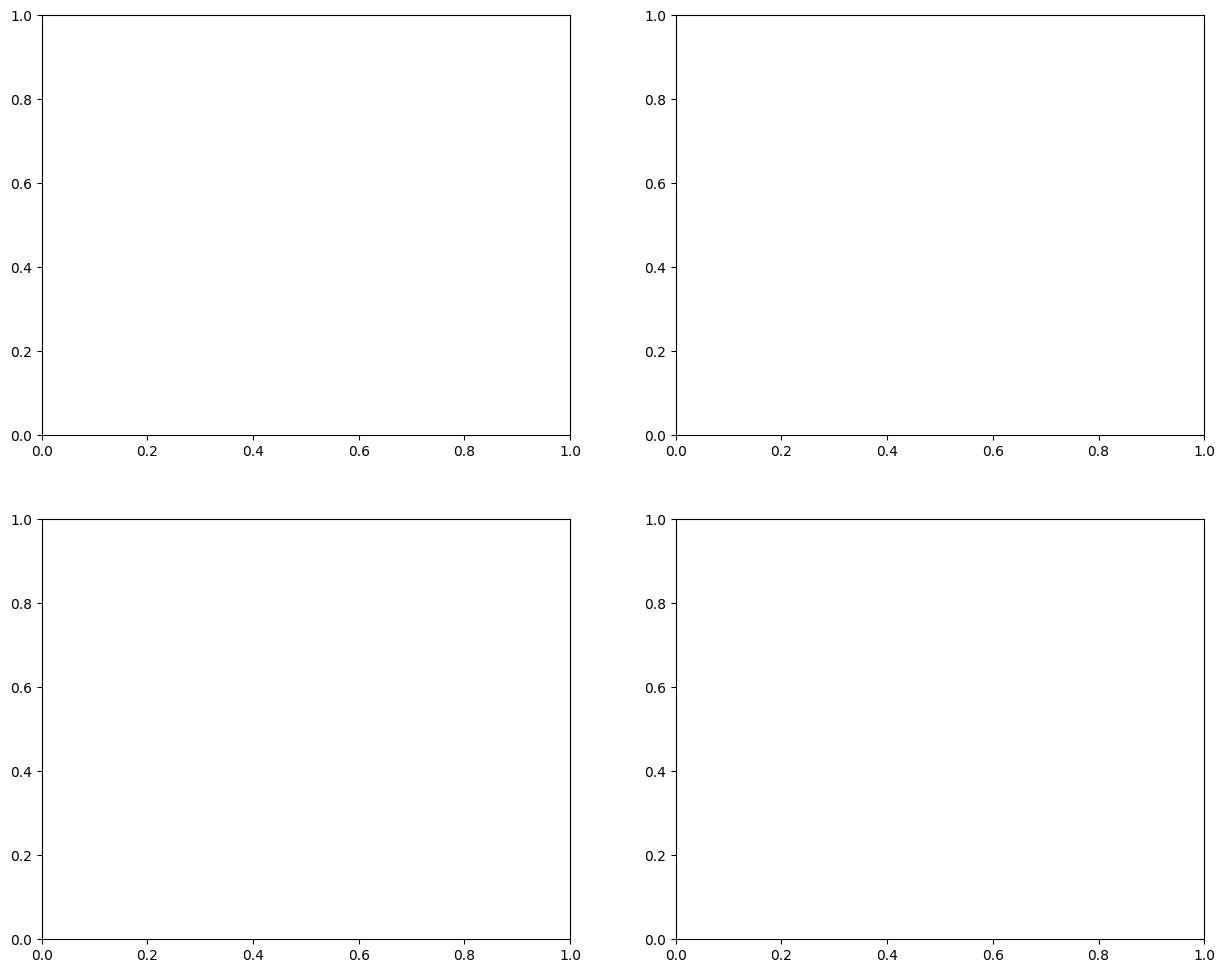

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import log_loss as multiclass_log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings
warnings.filterwarnings('ignore')

def apply_specialist_models_flexible(ensemble_probs, specialist_models, specialist_classes, 
                                   confidence_threshold=0.9, boost_probability=0.9):
    """
    Apply specialist model logic with flexible thresholds
    
    Args:
        ensemble_probs: Array of shape (n_samples, n_classes) with ensemble probabilities
        specialist_models: Dictionary mapping class to specialist model
        specialist_classes: List of classes that have specialist models
        confidence_threshold: Probability threshold below which to consult specialist models
        boost_probability: Probability to set when specialist agrees
        
    Returns:
        Modified probability array
    """
    modified_probs = ensemble_probs.copy()
    interventions = 0
    agreements = 0
    disagreements = 0
    
    for i in range(ensemble_probs.shape[0]):
        pred_class = np.argmax(ensemble_probs[i])
        pred_prob = ensemble_probs[i, pred_class]
        
        # Check if predicted class has specialist and probability is below threshold
        if pred_class in specialist_classes and pred_prob < confidence_threshold:
            interventions += 1
            specialist_model = specialist_models[pred_class]
            
            # Get specialist prediction
            sample_features = X_combined_test_selected_svm[i].reshape(1, -1)
            specialist_prob = specialist_model.predict_proba(sample_features)[0, 1]
            
            if specialist_prob > 0.5:
                # Specialist agrees - boost probability
                agreements += 1
                old_prob = modified_probs[i, pred_class]
                modified_probs[i, pred_class] = boost_probability
                
                # Redistribute remaining probability proportionally
                remaining_prob = 1 - boost_probability
                original_remaining = 1 - old_prob
                
                if original_remaining > 0:  # Avoid division by zero
                    for j in range(ensemble_probs.shape[1]):
                        if j != pred_class:
                            modified_probs[i, j] = modified_probs[i, j] * remaining_prob / original_remaining
            else:
                # Specialist disagrees - swap top two
                disagreements += 1
                top_indices = np.argsort(ensemble_probs[i])[-2:]
                temp = modified_probs[i, top_indices[0]]
                modified_probs[i, top_indices[0]] = modified_probs[i, top_indices[1]]
                modified_probs[i, top_indices[1]] = temp
    
    return modified_probs, interventions, agreements, disagreements

# Define parameter ranges
confidence_thresholds = np.arange(0.6, 0.95, 0.05)  # 0.6 to 0.9 in steps of 0.05
boost_probabilities = np.arange(0.80, 0.96, 0.02)   # 0.8 to 0.95 in steps of 0.02

print("Starting comprehensive threshold optimization...")
print(f"Testing {len(confidence_thresholds)} confidence thresholds: {confidence_thresholds}")
print(f"Testing {len(boost_probabilities)} boost probabilities: {boost_probabilities}")
print(f"Total combinations: {len(confidence_thresholds) * len(boost_probabilities)}")

# Store results
results = []

# Test all combinations
for conf_thresh, boost_prob in product(confidence_thresholds, boost_probabilities):
    # Apply specialist logic with current parameters
    modified_probs, interventions, agreements, disagreements = apply_specialist_models_flexible(
        y_proba_ensemble, 
        specialist_models, 
        specialist_classes, 
        confidence_threshold=conf_thresh,
        boost_probability=boost_prob
    )
    
    # Get predictions and evaluate
    modified_pred = np.argmax(modified_probs, axis=1)
    accuracy = accuracy_score(y_test, modified_pred)
    log_loss = multiclass_log_loss(y_test, modified_probs)
    
    # Count changes from original
    changes = np.sum(y_pred_ensemble != modified_pred)
    change_percent = changes / len(y_test) * 100
    
    # Store results
    results.append({
        'confidence_threshold': conf_thresh,
        'boost_probability': boost_prob,
        'accuracy': accuracy,
        'log_loss': log_loss,
        'interventions': interventions,
        'agreements': agreements,
        'disagreements': disagreements,
        'changes': changes,
        'change_percent': change_percent,
        'intervention_rate': interventions / len(y_test) * 100,
        'agreement_rate': agreements / interventions * 100 if interventions > 0 else 0
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("OPTIMIZATION RESULTS SUMMARY")
print("="*80)

# Find best configurations
best_accuracy = results_df.loc[results_df['accuracy'].idxmax()]
best_log_loss = results_df.loc[results_df['log_loss'].idxmin()]

print(f"\nOriginal Ensemble Performance:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"Log Loss: {ensemble_log_loss:.4f}")

print(f"\nBest Accuracy Configuration:")
print(f"Confidence Threshold: {best_accuracy['confidence_threshold']:.2f}")
print(f"Boost Probability: {best_accuracy['boost_probability']:.2f}")
print(f"Accuracy: {best_accuracy['accuracy']:.4f} (Δ: {best_accuracy['accuracy'] - ensemble_accuracy:+.4f})")
print(f"Log Loss: {best_accuracy['log_loss']:.4f} (Δ: {best_accuracy['log_loss'] - ensemble_log_loss:+.4f})")
print(f"Changes: {best_accuracy['changes']} ({best_accuracy['change_percent']:.1f}%)")
print(f"Interventions: {best_accuracy['interventions']} ({best_accuracy['intervention_rate']:.1f}%)")

print(f"\nBest Log Loss Configuration:")
print(f"Confidence Threshold: {best_log_loss['confidence_threshold']:.2f}")
print(f"Boost Probability: {best_log_loss['boost_probability']:.2f}")
print(f"Accuracy: {best_log_loss['accuracy']:.4f} (Δ: {best_log_loss['accuracy'] - ensemble_accuracy:+.4f})")
print(f"Log Loss: {best_log_loss['log_loss']:.4f} (Δ: {best_log_loss['log_loss'] - ensemble_log_loss:+.4f})")
print(f"Changes: {best_log_loss['changes']} ({best_log_loss['change_percent']:.1f}%)")
print(f"Interventions: {best_log_loss['interventions']} ({best_log_loss['intervention_rate']:.1f}%)")

# Top 10 configurations by accuracy
print(f"\nTop 10 Configurations by Accuracy:")
top_accuracy = results_df.nlargest(10, 'accuracy')[['confidence_threshold', 'boost_probability', 'accuracy', 'log_loss', 'change_percent']]
print(top_accuracy.to_string(index=False, float_format='%.4f'))

# Top 10 configurations by log loss (lowest)
print(f"\nTop 10 Configurations by Log Loss (lowest):")
top_log_loss = results_df.nsmallest(10, 'log_loss')[['confidence_threshold', 'boost_probability', 'accuracy', 'log_loss', 'change_percent']]
print(top_log_loss.to_string(index=False, float_format='%.4f'))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

## 12. Generate Final Predictions for Test Products


In [16]:
# Create features for test products
print("\nCreating features for test products...")

# 1. Create graph features for test products
print("\nExtracting graph features for test products...")
test_graph_features_final = extract_graph_features(G, test_products)
test_graph_features_final = test_graph_features_final.fillna(0)
test_graph_features_final_scaled = graph_scaler.transform(test_graph_features_final)
test_graph_sparse_final = csr_matrix(test_graph_features_final_scaled)
print(f"Graph features shape for test products: {test_graph_sparse_final.shape}")

# 2. Create Node2Vec embeddings for test products
test_node2vec_features_final = np.zeros((len(test_products), 128))
for i, node_id in enumerate(test_products):
    try:
        test_node2vec_features_final[i] = n2v_model.wv[str(node_id)]
    except KeyError:
        # If node not in embeddings, use zeros
        pass

# Scale the Node2Vec embeddings
test_node2vec_scaled_final = n2v_scaler.transform(test_node2vec_features_final)
test_node2vec_sparse_final = csr_matrix(test_node2vec_scaled_final)
print(f"Node2Vec features shape for test products: {test_node2vec_sparse_final.shape}")

# 3. Create price features for test products
test_price_features_final = create_price_features(test_products, price_df)
test_price_scaled_final = test_price_features_final.copy()
test_price_scaled_final[price_columns_to_scale] = price_scaler.transform(test_price_features_final[price_columns_to_scale])
test_price_features_array_final = test_price_scaled_final.values
test_price_sparse_final = csr_matrix(test_price_features_array_final)
print(f"Price features shape for test products: {test_price_sparse_final.shape}")

# COMBINE ALL FEATURES
print("\nCombining all features...")
X_combined_test_final = hstack([
    X_tfidf_test_comp, 
    test_graph_sparse_final,
    test_node2vec_sparse_final, 
    test_price_sparse_final
], format='csr')

print(f"Combined features shape for test products: {X_combined_test_final.shape}")

# Apply feature selection for different models
X_combined_test_final_selected = feature_selector.transform((X_combined_test_final))
X_combined_test_final_selected_svm = feature_selector_svm.transform((X_combined_test_final))

# Make predictions using all models
print("\nMaking predictions using all models...")
test_pred_proba_svm = svm_model.predict_proba(X_combined_test_final_selected_svm)
test_pred_proba_xgb = xgb_model.predict_proba(X_combined_test_final_selected)
test_pred_proba_nn = nn_model.predict(X_combined_test_final_selected)

# Combine predictions with weighted average
test_pred_proba_ensemble = (
    weights[0] * test_pred_proba_svm + 
    weights[1] * test_pred_proba_xgb + 
    weights[2] * test_pred_proba_nn
)

# Apply specialist model logic to the ensemble predictions
print("Applying specialist model logic to final predictions...")
# Create a dictionary of specialist models for the final test set
final_specialist_models = {}
for specialist_class in specialist_classes:
    model_filename = f'specialist_model_class_{specialist_class}.pkl'
    final_specialist_models[specialist_class] = joblib.load(model_filename)

# Define a function to apply specialist models to the test set
def apply_specialist_models_to_test(ensemble_probs, specialist_models, specialist_classes, features, threshold=0.9):
    """
    Apply specialist model logic to ensemble predictions for the test set
    
    Args:
        ensemble_probs: Array of shape (n_samples, n_classes) with ensemble probabilities
        specialist_models: Dictionary mapping class to specialist model
        specialist_classes: List of classes that have specialist models
        features: Features to use for specialist model predictions
        threshold: Probability threshold below which to consult specialist models
        
    Returns:
        Modified probability array
    """
    # Make a copy of the input probabilities to avoid modifying the original
    modified_probs = ensemble_probs.copy()
    
    # For each sample
    for i in range(ensemble_probs.shape[0]):
        # Get the predicted class and its probability
        pred_class = np.argmax(ensemble_probs[i])
        pred_prob = ensemble_probs[i, pred_class]
        
        # Check if the predicted class is one of the specialist classes and probability is below threshold
        if pred_class in specialist_classes and pred_prob < threshold:
            # Get the specialist model for this class
            specialist_model = specialist_models[pred_class]
            
            # Extract the features for this sample
            sample_features = features[i]
            
            # Reshape to 2D array for prediction
            sample_features_2d = sample_features.reshape(1, -1)
            
            # Get the specialist's prediction (probability of being the specialist class)
            specialist_prob = specialist_model.predict_proba(sample_features_2d)[0, 1]
            
            # If the specialist agrees (probability > 0.5)
            if specialist_prob > 0.5:
                # Bump the probability up to 0.9
                old_prob = modified_probs[i, pred_class]
                modified_probs[i, pred_class] = threshold
                
                # Calculate how much probability was added
                prob_added = threshold - old_prob
                
                # Distribute the added probability proportionally from other classes
                # to maintain sum = 1
                for j in range(ensemble_probs.shape[1]):
                    if j != pred_class:
                        # Reduce other probabilities proportionally
                        modified_probs[i, j] = modified_probs[i, j] * (1 - threshold) / (1 - old_prob)
            else:
                # Specialist disagrees, swap the two highest scores
                # Find the indices of the two highest probabilities
                top_indices = np.argsort(ensemble_probs[i])[-2:]
                
                # Swap the values
                temp = modified_probs[i, top_indices[0]]
                modified_probs[i, top_indices[0]] = modified_probs[i, top_indices[1]]
                modified_probs[i, top_indices[1]] = temp
    
    return modified_probs

# Apply the specialist model logic to the final test predictions
modified_test_pred_proba_ensemble = apply_specialist_models_to_test(
    test_pred_proba_ensemble, 
    final_specialist_models, 
    specialist_classes, 
    X_combined_test_final_selected,
    threshold=0.9
)

print(f"Predictions shape: {modified_test_pred_proba_ensemble.shape}")

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame()
predictions_df['product'] = test_products

# Add probability for each class
for i in range(modified_test_pred_proba_ensemble.shape[1]):
    predictions_df[f'class{i}'] = modified_test_pred_proba_ensemble[:, i].round(4)

# Save predictions to CSV
predictions_df.to_csv('predictions_with_specialists.csv', index=False)
print(f"Predictions saved to predictions_with_specialists.csv")

# Display the first few rows of the predictions
print("\nSample of predictions:")
print(predictions_df.head())



Creating features for test products...

Extracting graph features for test products...
Calculating degree centrality...
Calculating clustering coefficient...
Calculating PageRank...
Calculating triangle count...
Calculating degree...
Graph features shape for test products: (45502, 5)
Node2Vec features shape for test products: (45502, 128)
Price features shape for test products: (45502, 7)

Combining all features...
Combined features shape for test products: (45502, 2060153)

Making predictions using all models...
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 102s 72ms/step
Applying specialist model logic to final predictions...
Predictions shape: (45502, 16)
Predictions saved to predictions_with_specialists.csv

Sample of predictions:
  product  class0  class1  class2  class3  class4  class5  class6  class7  \
0   49957  0.0004  0.0135  0.0107  0.0002  0.0040  0.0461  0.0144  0.0029   
1  135386  0.0001  0.0003  0.0001  0.0000  0.0008  0.0456  0.0004  0.0013   
2  226880  0.0000  0.0007  0.9903  0.0

## 13. Summary and Conclusion


In [ ]:
print("Summary of Specialist Models Implementation:")
print("-" * 50)
print(f"Specialist models were trained for classes: {specialist_classes}")
print(f"Threshold for consulting specialist models: 0.9")
print(f"Original Ensemble Accuracy: {ensemble_accuracy:.4f}, Log Loss: {ensemble_log_loss:.4f}")
print(f"Modified Ensemble Accuracy: {modified_ensemble_accuracy:.4f}, Log Loss: {modified_ensemble_log_loss:.4f}")
print(f"Number of predictions changed by specialist models: {changes} ({changes/len(y_test)*100:.2f}%)")
print("-" * 50)
print("Specialist Model Logic:")
print("1. If the ensemble model predicts class 1, 10, or 12 with probability < 0.9:")
print("   a. Consult the specialist model for that class")
print("   b. If specialist agrees (prob > 0.5), bump probability to 0.9")
print("   c. If specialist disagrees, swap the two highest probability scores")
print("-" * 50)
print("Final predictions saved to: predictions_with_specialists.csv")